# **Predicting the perception of deprivation from VHR Satelite Images.**

## 0. Import libraries

Firstly, install and import the necessary libraries for this analysis.

In [1]:
import numpy as np
import os, sys
import pandas as pd
import glob
import re
from tensorflow import keras
import natsort
import sklearn
import tensorflow as tf
import datetime
import cv2
import shutil
import time
import tempfile
import h5py

In [2]:
from IPython.display import clear_output

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
from sklearn.metrics import accuracy_score
from osgeo import gdal
from osgeo import gdal_array
from natsort import natsorted
from keras.utils import np_utils
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 0.1 Import/define custom functions

Import custom functions

In [5]:
# Add local module to the path
src = os.path.abspath('../../SRC')
if src not in sys.path:
    sys.path.append(src)

In [6]:
# Import functions for processing time information
from processing_time import start_processing, print_processing_time
# Import function that checks and creates folder
from mkdir import check_create_dir
# Import functions for display
from display import Norma_Xpercentile

In [7]:
# Import custom colormap for the label maps
from colormap_matplotlib import Colormap
# Create the custom colormap for display of label raster
cmap_label,norm_label = Colormap(colors_list=['black','red','yellow','green','cyan','grey'], boundaries=[-1.0,1.0, 2.0, 3.0, 4.0, 5.0])

In [11]:
# Import function for ploting LOSS and accuracy curves
from plots import plot_loss, plot_accuracy

In [14]:
def read_array_from_hdf5(path, prob_included=True):
    # Load numpy arrays with TRAIN and TEST sets
    if prob_included:
        with h5py.File(path, "r") as f:
            X_train = np.asarray(f["X_train"])
            X_test = np.asarray(f["X_test"])
            p_train = np.asarray(f["p_train"])
            p_test = np.asarray(f["p_test"])
            y_train = np.asarray(f["y_train"])
            y_test = np.asarray(f["y_test"])
        # Check the shape of each sub-dataset 
        print("X_train.shape = %s"%str(X_train.shape))
        print("p_train.shape = %s"%str(p_train.shape))
        print("y_train.shape = %s"%str(y_train.shape))
        print("X_test.shape = %s"%str(X_test.shape))
        print("p_test.shape = %s"%str(p_test.shape))
        print("y_test.shape = %s"%str(y_test.shape))
        return X_train,X_test,p_train,p_test,y_train,y_test
    
    else: 
        with h5py.File(path, "r") as f:
            X_train = np.asarray(f["X_train"])
            X_test = np.asarray(f["X_test"])
            y_train = np.asarray(f["y_train"])
            y_test = np.asarray(f["y_test"])
        # Check the shape of each sub-dataset 
        print("X_train.shape = %s"%str(X_train.shape))
        print("y_train.shape = %s"%str(y_train.shape))
        print("X_test.shape = %s"%str(X_test.shape))
        print("y_test.shape = %s"%str(y_test.shape))
        return X_train,X_test,y_train,y_test

In [15]:
def display_random(**kwargs):
    X_train = kwargs.get("images_array")
    y_train = kwargs.get("label_array")
    if 'proba_array' in kwargs:
        p_train = kwargs.get("proba_array")
    # Get a random inded
    rdm_id = np.random.randint(len(X_train))
    if 'proba_array' in kwargs:
        # Plot one random patch extracted
        plt.figure(figsize=(10, 20))
        ax = plt.subplot(1, 3, 1)
        plt.imshow(Norma_Xpercentile(X_train[rdm_id,:,:,0:3],BGR2RGB=False))
        plt.title("Imagery", y=1.05, fontsize=8)
        ax = plt.subplot(1, 3, 2)
        plt.imshow(p_train[rdm_id,:,:], cmap="gray")  # Proba
        plt.title("Snorkel prpobability", y=1.05, fontsize=8)
        plt.subplots_adjust(wspace=0.2,hspace=0.3)
        ax = plt.subplot(1, 3, 3)
        plt.imshow(y_train[rdm_id,:,:], cmap=cmap_label, norm=norm_label)  # Labels
        plt.title("Snorkel Label", y=1.05, fontsize=8)
        plt.subplots_adjust(wspace=0.2,hspace=0.3)
    else:
        # Plot one random patch extracted
        plt.figure(figsize=(7, 14))
        ax = plt.subplot(1, 2, 1)
        plt.imshow(Norma_Xpercentile(X_train[rdm_id,:,:,0:3],BGR2RGB=False))
        plt.title("Imagery", y=1.05, fontsize=8)
        ax = plt.subplot(1, 2, 2)
        plt.imshow(y_train[rdm_id,:,:], cmap=cmap_label, norm=norm_label)  # Labels
        plt.title("Snorkel Label", y=1.05, fontsize=8)
        plt.subplots_adjust(wspace=0.2,hspace=0.3)

## 0.2 Check availability of the GPU

Check the version of Tensorflow. It should be 2.8.0

In [16]:
print(tf.__version__)

2.10.0


Check the output of nvidia-smi utility to monitor the GPU usage.

In [17]:
! nvidia-smi

Tue Oct 25 13:01:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0  On |                  N/A |
| 24%   35C    P8    23W / 215W |   1500MiB /  7981MiB |     11%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
%run ../../SRC/Check_GPU_available.py

1 Physical GPUs, 1 Logical GPUs
Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
0.8722070539370179
GPU (s):
0.07849264913238585
GPU speedup over CPU: 11x


# 1. Data preparation 

**In this part, we load the data prepared before.**

In [19]:
# Set ID of experiment
experiment_id = 1

In [20]:
# Set patch size
psize = 256

In [21]:
# Define working path 
root = "/home/tais"
image_path = os.path.join(root, "data", "ISPRS_semantic_labeling_Vaihingen","top")
label_path = os.path.join(root, "result", "snorkel_predicts")
output_path = os.path.join(root, "result", "DL_results")
data_path = os.path.join(output_path, "data")
model_path = os.path.join(output_path, "model")
results_path = os.path.join(output_path, "results", "Exp_%s_psize_%s"%(experiment_id,psize))

In [22]:
#Check and create output data directory if needed
list_directories = [output_path, model_path, data_path, results_path]
for path in list_directories:
    check_create_dir(path)  

The folder '/home/tais/result/DL_results' already exists
The folder '/home/tais/result/DL_results/model' already exists
The folder '/home/tais/result/DL_results/data' already exists
The folder '/home/tais/result/DL_results/results/Exp_1_psize_256' already exists


In [23]:
# Read numpy arrays from HDF5 file
X_train,X_test,p_train,p_test,y_train,y_test = read_array_from_hdf5(os.path.join(data_path,"patches_fixed_%s.hdf5"%psize), prob_included=True)

X_train.shape = (966, 256, 256, 3)
p_train.shape = (966, 256, 256)
y_train.shape = (966, 256, 256)
X_test.shape = (242, 256, 256, 3)
p_test.shape = (242, 256, 256)
y_test.shape = (242, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


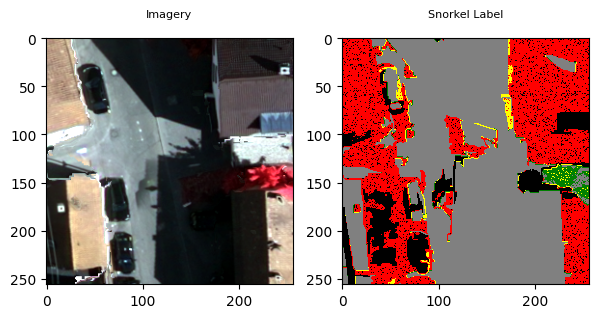

In [24]:
# Display random patch from the dataset
display_random(images_array=X_train, label_array=y_train)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


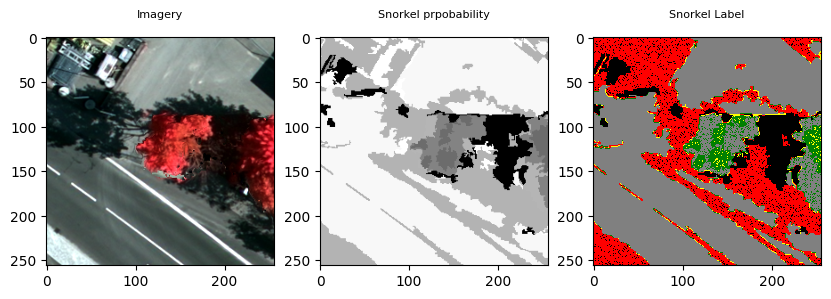

In [25]:
# Display random patch from the dataset
display_random(images_array=X_train, proba_array=p_train, label_array=y_train)

# 2 Model definition
In this part, we use a network pre-trained on ImageNet to predict the deprivation degree. We droped the classification head and plugged a regression head on it. Then, we fine-tune weights on our own data.
Since Tensorflow is difficult to configure to avoid stochiastic behaviour [(Alahmari et al. 2020)](https://ieeexplore.ieee.org/document/9266043/), the implement a multiple run approach. 

### 2.1 Data Augmentation Definition

In [26]:
# Set Image Data Generator
datagen = ImageDataGenerator()

### 2.2 Models Architecture Definition

**DeepLabV3+**

In [27]:
def convolution_block(
    block_input,
    #num_filters=256,
    num_filters=128,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding=padding,
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

In [28]:
def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]),
        interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

In [29]:
def DeeplabV3Plus(image_size, num_classes):
    model_input = keras.Input(shape=(image_size, image_size, 3))
    resnet50 = keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)

# 3 Train model

In [31]:
# Parameters
IMAGE_SIZE = psize
BATCH_SIZE = 4
NUM_CLASSES = 6
NUM_TRAIN_IMAGES = len(X_train)
NUM_VAL_IMAGES = len(X_test)
NB_EPOCH = 20

In [32]:
# Create a new model instance and print summary
model = DeeplabV3Plus(image_size=IMAGE_SIZE, num_classes=NUM_CLASSES)
model.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                             

In [33]:
# Define loss function as Categorical Cross Entropy
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [34]:
# Define callbacks
checkpoint_filepath = os.path.join(results_path,'Best_performed_model.hdf5')
checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
csv_path = os.path.join(results_path, "run_log.csv")
csv_logger = tf.keras.callbacks.CSVLogger(csv_path, separator=";", append=True)
callbacklist = [checkpoint, csv_logger]
# Compile the model with Adam optimizer
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),loss=loss,metrics=["accuracy"])

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=False, seed=3), 
                    steps_per_epoch=int(len(X_train)/BATCH_SIZE),
                    validation_data = (X_test,y_test), 
                    epochs=NB_EPOCH,
                    callbacks = callbacklist)

Epoch 1/20
241/241 [==============================] - ETA: 0s - loss: 0.7162 - accuracy: 0.7304
Epoch 1: val_accuracy improved from -inf to 0.16120, saving model to /home/tais/result/DL_results/results/Exp_1_psize_256/Best_performed_model.hdf5
241/241 [==============================] - 35s 103ms/step - loss: 0.7162 - accuracy: 0.7304 - val_loss: 3.6589 - val_accuracy: 0.1612
Epoch 2/20
241/241 [==============================] - ETA: 0s - loss: 0.5525 - accuracy: 0.7846
Epoch 2: val_accuracy did not improve from 0.16120
241/241 [==============================] - 17s 69ms/step - loss: 0.5525 - accuracy: 0.7846 - val_loss: 3.4258 - val_accuracy: 0.1612
Epoch 3/20
241/241 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7981
Epoch 3: val_accuracy improved from 0.16120 to 0.17043, saving model to /home/tais/result/DL_results/results/Exp_1_psize_256/Best_performed_model.hdf5
241/241 [==============================] - 19s 78ms/step - loss: 0.5145 - accuracy: 0.7981 - va

In [ ]:
# Plot history and save the figures
save_path = os.path.join(results_path,"Loss_curves.jpg")
plot_loss(history, save_path, ylim=[0,6], show=True)

In [ ]:
# Plot history and save the figures
save_path = os.path.join(results_path,"Accuracy_curves.jpg")
plot_accuracy(history, save_path, ylim=[0,1], show=True)

# 4. Predict on validation set

In [114]:
# Load the weights from the best checkpoint
model.load_weights(checkpoint_filepath)
# run the model on the train and test datasets 
y_pred_train = model.predict(X_train[0:5,:,:,:])
y_pred_test = model.predict(X_test[0:5,:,:,:]) 

1/1 [==============================] - 0s 38ms/step


In [116]:
accuracy_score(y_train[0:5], y_pred_train)

ValueError: unknown is not supported

In [ ]:
accuracy_score(y_train, y_pred_train)

In [118]:
y_train.shape

(966, 256, 256)

In [119]:
y_pred_train.shape

(5, 256, 256, 6)